## Scintillation detector data for unfolding

*Erik Hogenbirk, ehogenbi@nikhef.nl, May/June 2016 *

The notebook here is to read in the data read from a NE213 scintillation detector. The output is a 2d histogram with on the x axis the energy (in channels, uncalibrated) and on the y axis some discrimination parameter. It is yet unknown what this is, exactly.

This notebook reads the following datasets:
  * Gamma calibration. There are three datasets, corresponding to three gamma sources. As some of these emit multiple gamma energies, this gives a calibration on six points.
  * Background. We need this to take away the gamma background. Further explanation given further on;
  * Neutron generator data. This was taken at different positions and NG settings.
  
There are some decisions that need to be made... The most important:
  * **Gamma calibration**: We need to calibrate on the Coompton edge, since the NE213 consists of very low-Z material and no photopeak is visible. How do we select the photopeak? The best would be a full MC matching, which I believe they would do at PTB. Maybe we could ask them what scaling they retrieve? At the moment, we just select the 50% amplitude point.
  * **Background rejection**: We can either cut away the gamma background (for instance, with some percentile) or subtract the background.
  * **Combination**: Do we combine all NG datasets, or do we analyze them separately? We can have more statistics, but is it safe to assume that the energy spectrum is the same at different positions and different NG settings?

### Function definitions

In [1]:
# This notebook has some special functions that are stashed away.
# Most important functions:
#  - get_spectrum : read the spectrum from the ASCII file
#  - find_line: auxilary function for get_spectrum to find the start position in the ASCII file.
#  - get_fwhm_pos : find the position of the half maximum for the gamma calibration.
#  - get_compton_energy: calculate Compton edge energy based on gamma initial energy
%run function_definitions.ipynb

### Data location

In [3]:
cal_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_8.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_9.MPA',
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_10.MPA']
cal_labels_0 = [
    'Bi-207',
    'Na-22',
    'Cs-137']
bg_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_12.mpa',
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_1.mpa']
bg_livetimes_0 = [
    36001.78,
    40002.56
    ]
ng_filenames_0 = [
    './PTB_DATA/2016_MAY_31/2016_MAY_31_2_5MeV_NE213_FG_7.mpa', # 50 kV 2.5 mA 0°
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_1.mpa', # 50 kV 2.5 mA 0° (SAME SETTINGS!)
    './PTB_DATA/2016_JUN_01/2016_JUN_01_2_5MeV_NE213_FG_2.mpa', # 40 kV 1.0 mA +140°
    './PTB_DATA/2016_JUN_02/2016_JUN_02_2_5MeV_NE213_FG_2.mpa', # 40 kV 0.5 mA +140°
    './PTB_DATA/2016_JUN_03/2016_JUN_03_2_5MeV_NE213_FG_1.mpa', # 50 kV 0.5 mA +140°
    ]
ng_livetimes_0 = [
    9806.20,
    11950.19,
    22654.55,
    46199.75,
    24747.66
    ]

### Gamma calibration

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


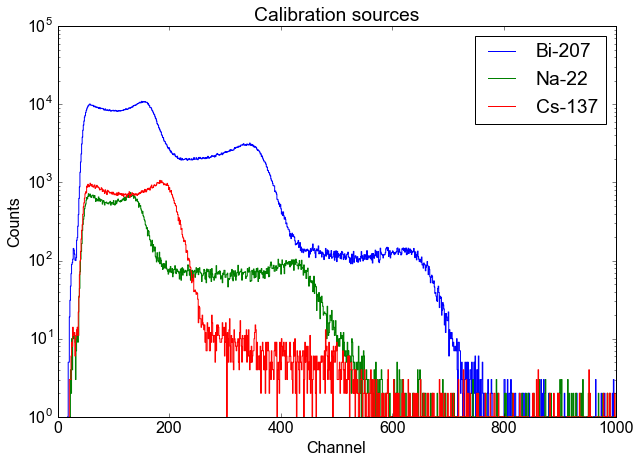

In [4]:
# Here we import the spectra one by one and plot them
my_colors = ['blue', 'green', 'red']
for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    plt.plot(spec,linestyle='steps', label=label, color=color)
#     fwhm_pos = get_fwhm_pos(spec)
#     plt.axvline(get_fwhm_pos(spec), color=color)
plt.yscale('log')
plt.title("Calibration sources")
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.xlim(0,1000)
plt.legend()
plt.show()

In [5]:
# Now, determine the position of the Compton edges
# We make two lists: one storing the energy in keV and one the index of the half-max sample
energy_list   = []
fwhm_pos_list = []

for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    if label == 'Bi-207':
        # Bi-207 has three gamma ray energies, so three Compton edges to find
        # https://ehs.ucsd.edu/rad/radionuclide/Bi-207.pdf
        energy_list.append(get_compton_energy(570.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1064.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:500]) + 300)
        energy_list.append(get_compton_energy(1770.))
        fwhm_pos_list.append(get_fwhm_pos(spec[500:800]) + 500)
    if label == 'Na-22':
        # From Na-22 we get 511 keV from positron allihilation and 1274 from gamma
        energy_list.append(get_compton_energy(511.))
        fwhm_pos_list.append(get_fwhm_pos(spec))
        energy_list.append(get_compton_energy(1274.))
        fwhm_pos_list.append(get_fwhm_pos(spec[300:600]) + 300)
    if label == 'Cs-137':
        # Only 662 keV
        energy_list.append(get_compton_energy(662.))
        fwhm_pos_list.append(get_fwhm_pos(spec))


Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


In [6]:
# Now perform the calibration based on linear fit
from scipy.optimize import curve_fit
p_scale, _ = curve_fit(poly_1, energy_list, fwhm_pos_list)
p_scale_and = [6, 1/4.775*2]

# Invert relation
p_scale_to_e = [- p_scale[0] / p_scale[1], 1 / p_scale[1]]
p_scale_to_e_and = [- p_scale_and[0] / p_scale_and[1], 1 / p_scale_and[1]]
# e_scale is the important list: it contains the energy in keV
# This is basically the x axis for all our next plots!
e_scale = np.array([poly_1(x, *p_scale_to_e) for x in range(4096)])
e_scale_and = np.array([poly_1(x, *p_scale_to_e_and) for x in range(4096)])

print("Erik Method:    Offset: %.2f channels, slope: %.4f channels/keV" % (p_scale[0], p_scale[1]))
print("Andreas Method: Offset: %.2f channels, slope: %.4f channels/keV" % (p_scale_and[0], p_scale_and[1]))


Erik Method:    Offset: 12.60 channels, slope: 0.4197 channels/keV
Andreas Method: Offset: 6.00 channels, slope: 0.4188 channels/keV


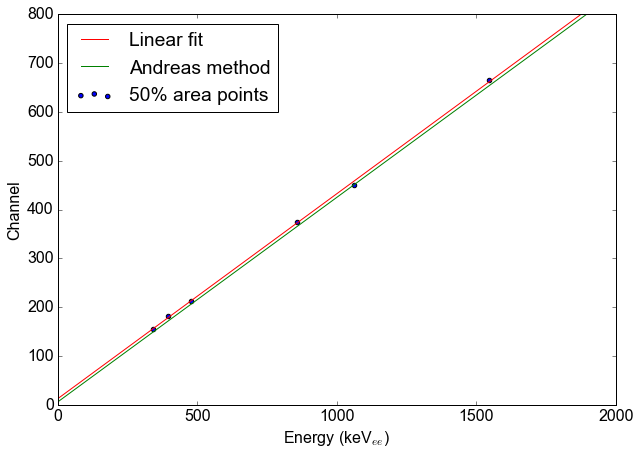

In [7]:
# Check out calibration
plt.scatter(energy_list, fwhm_pos_list, label='50% area points')
plt.plot(range(2000), [poly_1(x, *p_scale) for x in range(2000)], color='red', label='Linear fit')
plt.plot(range(2000), [poly_1(x, *p_scale_and) for x in range(2000)], color='green', label='Andreas method')

plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Channel')
plt.xlim(0,2000)
plt.ylim(0,800)
plt.legend(loc='upper left')
plt.show()

Spectrum containing 4096 samples read, total 1778316 counts
Spectrum containing 4096 samples read, total 133069 counts
Spectrum containing 4096 samples read, total 177012 counts


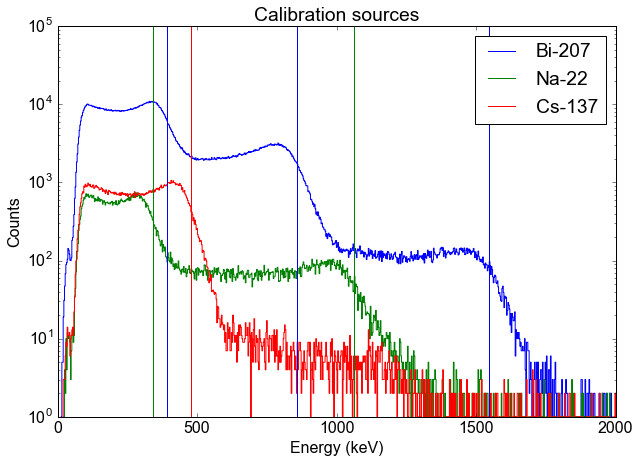

In [8]:
# Now plot the spectra again, but include with correct x scale and the Compton edge energy
my_colors = ['blue', 'green', 'red']
for filename, label, color in zip(cal_filenames_0, cal_labels_0, my_colors):
    line_n = find_line_start(filename, '[DATA')
    spec = get_spectrum(filename, line_n)
    plt.plot(e_scale,spec,linestyle='steps', label=label, color=color)

for i, e in enumerate(np.sort(energy_list)):
    if i==0 or i==4:
        c = 'green'
    if i==1 or i==3 or i==5:
        c = 'blue'
    if i==2:
        c='red'
    plt.axvline(e, c=c)
plt.yscale('log')
plt.title("Calibration sources")
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.xlim(0,2000)
plt.legend()
plt.show()

#### Toggle calibration

In [9]:
guy_to_trust = 'andreas'

if guy_to_trust == 'andreas':
    e_scale = e_scale_and
    print("Selected Andreas' energy scale!")
if guy_to_trust == 'erik':
    e_scale = e_scale
    print("Selected Eriks energy scale!")

Selected Andreas' energy scale!


### Load neutron and background data

In [10]:
# NG data
spec2d_list = []
for ng_filename in ng_filenames_0:
    line_n = find_line_start(ng_filename,'[CDAT2')
    spec2d_raw = get_spectrum(ng_filename, line_n)
    spec2d = np.reshape(spec2d_raw, (1024,4096))
    spec2d_list.append(spec2d)
#spec2d = sum(spec2d_list)

# NOTE THIS IS A NEW LINE... Only analize the first run, not all combined!
# NOTE modified AGAIN August 2016. spec2d = spec2d_list[0] -> spec2d = spec2d_list[0] + spec2d_list[1]
spec2d = spec2d_list[0] + spec2d_list[1]

Spectrum containing 4194304 samples read, total 976692 counts
Spectrum containing 4194304 samples read, total 1244420 counts
Spectrum containing 4194304 samples read, total 1867828 counts
Spectrum containing 4194304 samples read, total 3781471 counts
Spectrum containing 4194304 samples read, total 2050478 counts


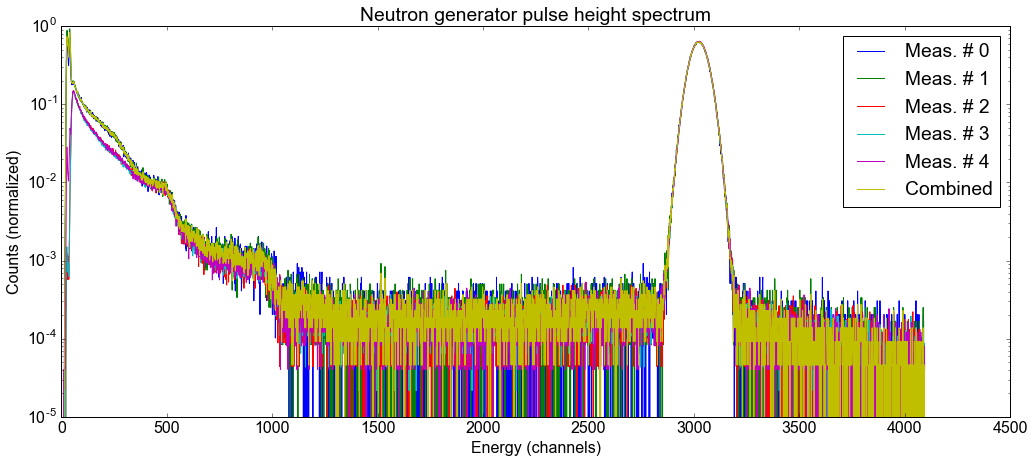

In [15]:
# Check that spectra coincide
scale_it = True # Toggle scaling by the total livetime
plt.figure(figsize=(17,7))
for i, spec in enumerate(spec2d_list):
    if scale_it:
        #norm_fac = 1./np.sum(spec)
        norm_fac = 1/ng_livetimes_0[i]
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
    
if scale_it:
    norm_fac = 1./(ng_livetimes_0[0] + ng_livetimes_0[1])
else:
    norm_fac = 1.
plt.plot(norm_fac*np.sum(spec2d, axis=0), label='Combined 0 and 1')
plt.yscale('log')
plt.legend()
plt.title('Neutron generator pulse height spectrum')
plt.xlabel('Energy (channels)')
if scale_it:
    plt.ylabel('Counts (normalized)')
else:
    plt.ylabel('Counts')
plt.show()

In [16]:
# BG data
spec2d_bg_list = []
for bg_filename in bg_filenames_0:
    line_n = find_line_start(bg_filename,'[CDAT2')
    spec2d_raw = get_spectrum(bg_filename, line_n)
    spec2d_bg = np.reshape(spec2d_raw, (1024,4096))
    spec2d_bg_list.append(spec2d_bg)
# Sum the background
spec2d_bg = sum(spec2d_bg_list)

Spectrum containing 4194304 samples read, total 2968699 counts
Spectrum containing 4194304 samples read, total 3252444 counts


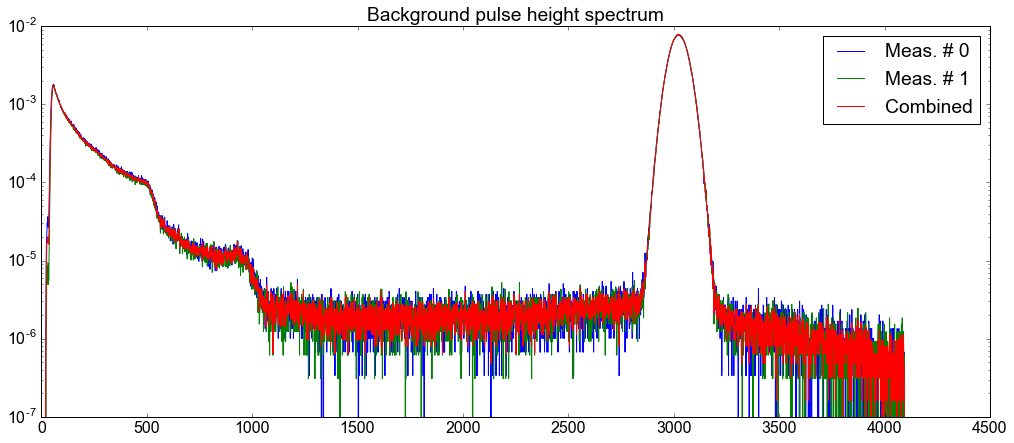

In [17]:
# Check that spectra coincide
scale_it = True # Toggle scaling by the total number of counts
plt.figure(figsize=(17,7))
for i, spec in enumerate(spec2d_bg_list):
    if scale_it:
        norm_fac = 1./np.sum(spec)
    else:
        norm_fac = 1.
    plt.plot(norm_fac*np.sum(spec, axis=0), label='Meas. # %d' % i)
if scale_it:
    norm_fac = 1./np.sum(spec2d_bg)
else:
    norm_fac = 1.
plt.plot(norm_fac*np.sum(spec2d_bg, axis=0), label='Combined')
plt.yscale('log')
plt.title('Background pulse height spectrum')
plt.legend()
plt.show()

### Cut background away

One thing we can do is cut the BG away based on the background discrimination parameter. For this, we have to calculate some cut parameter. I build a class to perform the cut based on a percentile of the BG distribution in y.

#### Cut class defintion

In [18]:
class Cut:
    '''
    Produce a cut function to cut on a percentile list.
    '''
    
    pct = 0.
    pct_list = [True for x in range(4096) ] 
    x_thr = 0.
    y_thr = 0.
    
    def get_percentile(self, spec2d, pct):
        self.pct_list = []
        self.pct = pct
        for x in range(len(spec2d[0])):
            self.pct_list.append(self.get_percentile_pos(spec2d[:,x],pct))
        
    def get_percentile_pos(self, dist, percent):
        tot = sum(dist)
        count = 0
        for i, x in enumerate(dist):
            if count >= tot*percent/100.:
                return i
            count += x
        # We should never arrive here
        print('WARNING! Error in get_percentile_pos')
        return -1
    
    def f_cut(self, x, y):
        '''
        FALSE = CUT
        TRUE = KEEP
        '''
        cut_y = self.pct_list[x-1]
        if y < cut_y:
            return False
        if x < self.x_thr:
            return False
        if y < self.y_thr:
            return False
        else:
            return True
        
    def plot_bounds(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)
        plt.axvline(self.x_thr, **kwargs)
        plt.axhline(self.y_thr, **kwargs)
        
    def plot_percentile(self, **kwargs):
        plt.plot(range(len(self.pct_list)), self.pct_list, **kwargs)

#### Calculate cuts

In [19]:
cut_list = []
for percentile in [99.0, 99.5]:
    cut = Cut()
    cut.get_percentile(spec2d_bg, percentile)
    cut_list.append(cut)

#### Show cuts on background and foreground

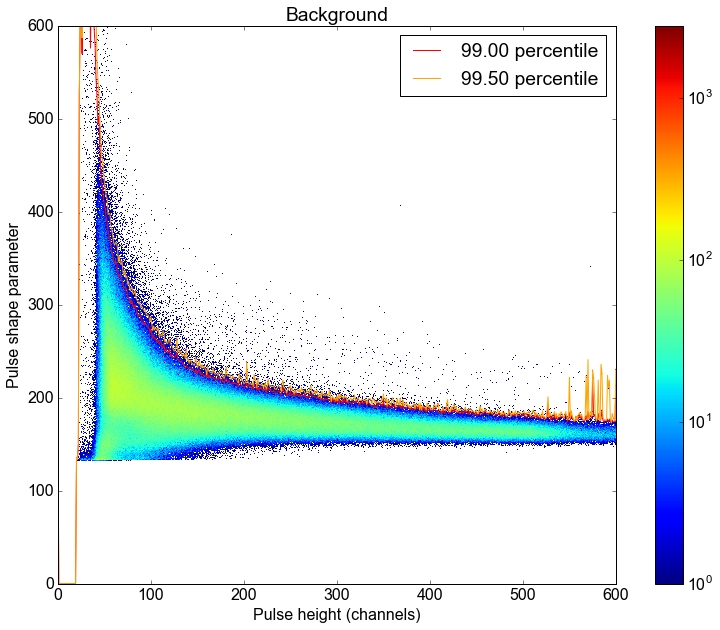

In [20]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d_bg, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('Background')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

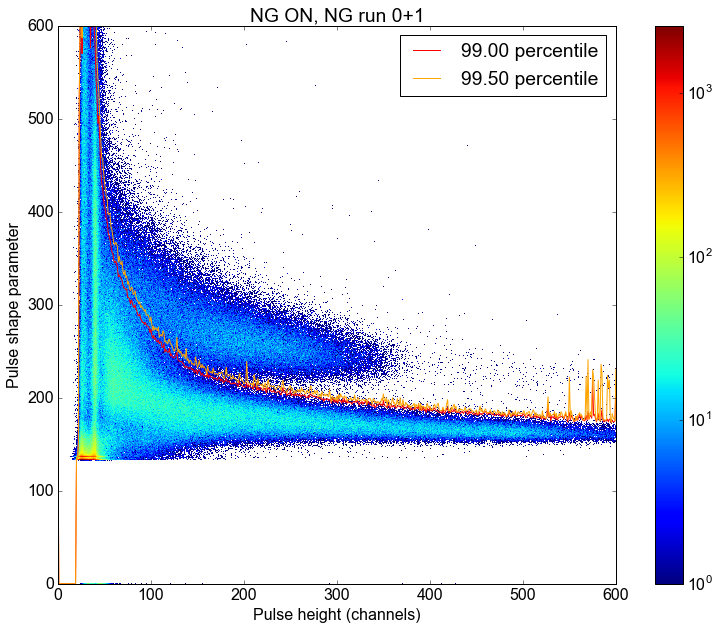

In [21]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
for cut, color in zip(cut_list, ['red', 'orange', 'green', 'purple', 'black']):
    cut.plot_percentile(label='%.2f percentile' % cut.pct, color=color)
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON, NG run 0+1')
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

#### Apply cut

In [22]:
# cut_list[1] means we're taking the 99.5 % cut
cut = cut_list[1]
cut.x_thr = 60.
spec2d_cut = cut_hist2d(spec2d, cut.f_cut)
spec2d_bg_cut = cut_hist2d(spec2d_bg, cut.f_cut)

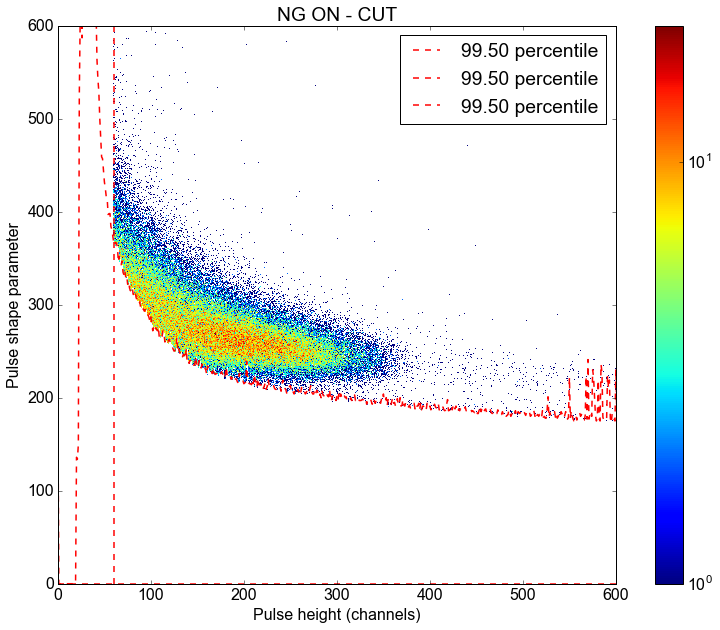

In [23]:
plt.figure(figsize=(14,10))
im = plt.imshow(spec2d_cut, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())
plt.colorbar()
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('NG ON - CUT')
cut.plot_bounds(color='red', ls='--', lw=1.5, label='%.2f percentile' % cut.pct)
plt.legend()
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()

#### Calculate cut spectra for all NG runs

In [26]:
# Settings equal for all runs
cut = cut_list[1]
cut.x_thr = 60.

# Now, for all runs:
# - Take 2d spectrum
# - Apply cuts based on BG percentiles
# - Project on x axis to obtain 1d (energy) spectrum
# - Divide by lifetime or run 
fg_0_disc = 1/ng_livetimes_0[0]*np.sum(cut_hist2d(spec2d_list[0], cut.f_cut), axis=0)
fg_1_disc = 1/ng_livetimes_0[1]*np.sum(cut_hist2d(spec2d_list[1], cut.f_cut), axis=0)
fg_2_disc = 1/ng_livetimes_0[2]*np.sum(cut_hist2d(spec2d_list[2], cut.f_cut), axis=0)
fg_3_disc = 1/ng_livetimes_0[3]*np.sum(cut_hist2d(spec2d_list[3], cut.f_cut), axis=0)
fg_4_disc = 1/ng_livetimes_0[4]*np.sum(cut_hist2d(spec2d_list[4], cut.f_cut), axis=0)



# Calculate errors:
# - Assume only Poissonian errors
# WARNING: - uncertainty on cut is NOT taken into account
# WARNING: - zero error for zero count, screws all fits up.
fg_0_disc_err = 1/ng_livetimes_0[0]*np.sqrt(np.sum(cut_hist2d(spec2d_list[0], cut.f_cut), axis=0))
fg_1_disc_err = 1/ng_livetimes_0[1]*np.sqrt(np.sum(cut_hist2d(spec2d_list[1], cut.f_cut), axis=0))
fg_2_disc_err = 1/ng_livetimes_0[2]*np.sqrt(np.sum(cut_hist2d(spec2d_list[2], cut.f_cut), axis=0))
fg_3_disc_err = 1/ng_livetimes_0[3]*np.sqrt(np.sum(cut_hist2d(spec2d_list[3], cut.f_cut), axis=0))
fg_4_disc_err = 1/ng_livetimes_0[4]*np.sqrt(np.sum(cut_hist2d(spec2d_list[4], cut.f_cut), axis=0))

# Also for BG, because this is how much of the BG leaks into signal!
bg_disc = 1/sum(bg_livetimes_0)*np.sum(cut_hist2d(spec2d_bg, cut.f_cut), axis=0)

#### Show cut pulse height spectra

Here we show two things: the BG passing the cut (needs to be scaled by the livetime!) and the 

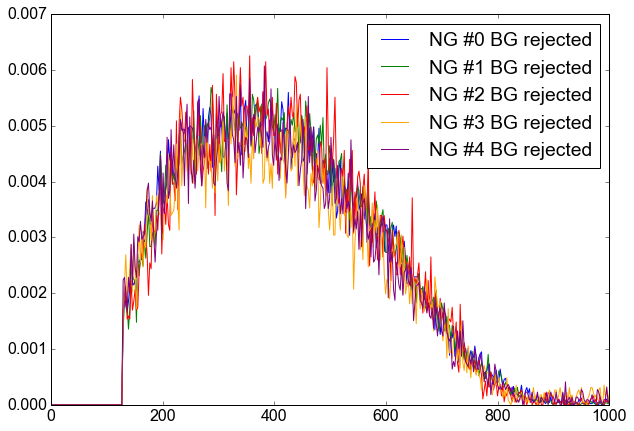

In [47]:
plt.plot(e_scale, 1/sum(fg_0_disc[0:2000])*fg_0_disc, color='blue', label='NG #0 BG rejected')
plt.plot(e_scale, 1/sum(fg_1_disc[0:2000])*fg_1_disc, color='green', label='NG #1 BG rejected')
plt.plot(e_scale, 1/sum(fg_2_disc[0:2000])*fg_2_disc, color='red', label='NG #2 BG rejected')
plt.plot(e_scale, 1/sum(fg_3_disc[0:2000])*fg_3_disc, color='orange', label='NG #3 BG rejected')
plt.plot(e_scale, 1/sum(fg_4_disc[0:2000])*fg_4_disc, color='purple', label='NG #4 BG rejected')
#plt.plot(e_scale, bg_disc, color='black', label='BG leakage')

plt.xlim(0,1000)
plt.ylim(0,0.007)
plt.legend()
#plt.yscale('log')


### Subtract BG

#### Plot spectra

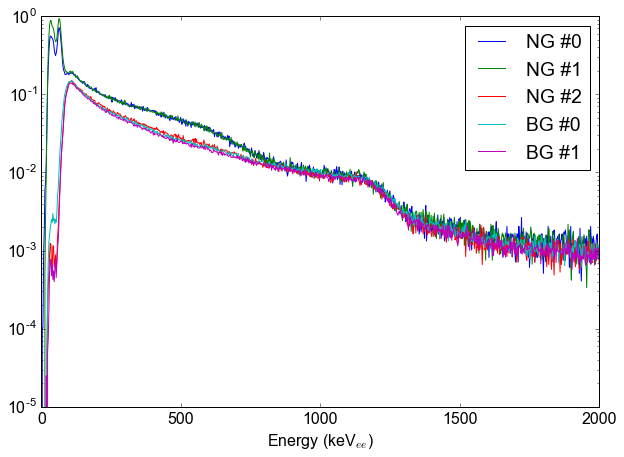

In [21]:
for i in range(len(spec2d_list)):
    plt.plot(e_scale, 1/ng_livetimes_0[i]*np.sum(spec2d_list[i],axis=0), label = 'NG #%d' % i)
for i in range(len(spec2d_bg_list)):
    plt.plot(e_scale, 1/bg_livetimes_0[i]*np.sum(spec2d_bg_list[i],axis=0), label = 'BG #%d' % i)

plt.xlabel('Energy (keV$_{ee}$)')
plt.legend()
plt.xlim(0,2000)
plt.yscale('log')

#### Compute spectra and errors

In [22]:
# Compute the livetime-corrected energy spectra
fg   = 1/(ng_livetimes_0[0] + ng_livetimes_0[0])*np.sum((spec2d_list[0] + spec2d_list[1]),axis=0)
fg_0 = 1/ng_livetimes_0[0]*np.sum(spec2d_list[0],axis=0)
fg_1 = 1/ng_livetimes_0[1]*np.sum(spec2d_list[1],axis=0)
fg_2 = 1/ng_livetimes_0[2]*np.sum(spec2d_list[2],axis=0)
fg_3 = 1/ng_livetimes_0[3]*np.sum(spec2d_list[3],axis=0)
fg_4 = 1/ng_livetimes_0[4]*np.sum(spec2d_list[4],axis=0)


# Combine BG: take sum of counts and sum of livetimes
bg = (1/sum(bg_livetimes_0))*(np.sum(spec2d_bg_list[0],axis=0) + np.sum(spec2d_bg_list[1],axis=0))

# Compute the errors
fg_err   = 1/(ng_livetimes_0[0] + ng_livetimes_0[1])*np.sqrt(np.sum((spec2d_list[0] + spec2d_list[1]),axis=0))
fg_0_err = 1/ng_livetimes_0[0]*np.sqrt(np.sum(spec2d_list[0],axis=0))
fg_1_err = 1/ng_livetimes_0[1]*np.sqrt(np.sum(spec2d_list[1],axis=0))
fg_2_err = 1/ng_livetimes_0[2]*np.sqrt(np.sum(spec2d_list[2],axis=0))
fg_3_err = 1/ng_livetimes_0[3]*np.sqrt(np.sum(spec2d_list[3],axis=0))
fg_4_err = 1/ng_livetimes_0[4]*np.sqrt(np.sum(spec2d_list[4],axis=0))

bg_err = (1/sum(bg_livetimes_0))*np.sqrt(
    (np.sum(spec2d_bg_list[0],axis=0) + np.sum(spec2d_bg_list[1],axis=0)))

# Subtract BG
fg_sub = fg - bg
fg_0_sub = fg_0 - bg
fg_1_sub = fg_1 - bg
fg_2_sub = fg_2 - bg
fg_3_sub = fg_3 - bg
fg_4_sub = fg_4 - bg

# Compute errors for subtracted BG plot
fg_sub_err = np.sqrt(fg_err**2 + bg_err**2)
fg_0_sub_err = np.sqrt(fg_0_err**2 + bg_err**2)
fg_1_sub_err = np.sqrt(fg_1_err**2 + bg_err**2)
fg_2_sub_err = np.sqrt(fg_2_err**2 + bg_err**2)
fg_3_sub_err = np.sqrt(fg_3_err**2 + bg_err**2)
fg_4_sub_err = np.sqrt(fg_4_err**2 + bg_err**2)

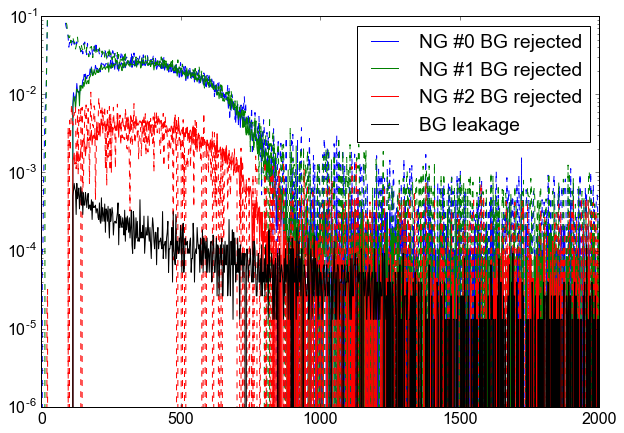

In [23]:
plt.plot(e_scale, fg_0_disc, color='blue', label='NG #0 BG rejected')
plt.plot(e_scale, fg_0_sub, color='blue',ls='--')
plt.plot(e_scale, fg_1_disc, color='green', label='NG #1 BG rejected')
plt.plot(e_scale, fg_1_sub, color='green', ls='--')
plt.plot(e_scale, fg_2_disc, color='red', label='NG #2 BG rejected')
plt.plot(e_scale, fg_2_sub, color='red', ls='--')
plt.plot(e_scale, bg_disc, color='black', label='BG leakage')

plt.xlim(0,2000)
plt.ylim(1e-6, 1e-1)
plt.legend()
plt.yscale('log')

### Investigate high energy population

#### Simple rebinning

In [52]:
def get_percentile_location(arr, pct):
    '''
    No idea why fucking numpy doesnt work on 1d arrays gvd
    '''
    total = sum(arr)
    current_sum = 0.
    i = 0
    while current_sum < total*pct:
        current_sum += arr[i]
        i += 1
    return i

In [53]:
def rebin(arr, factor=2, mode='avg'):
    '''
    Rebin an array. Take integer factor. Modes available:
      - avg: average. Default.
      - sum: Sum.
      - quad: adding all in quadrature. Mostly for errors.
      - quad_avg: adding all in quadrature, then taking average. For errors on averages.
    '''
    if mode == 'avg':
        rebin = np.array([1/factor*sum(arr[i:i + factor]) for i in np.arange(0, len(arr), factor)])
    elif mode == 'sum':
        rebin = np.array([sum(arr[i:i + factor]) for i in np.arange(0, len(arr), factor)])
    elif mode == 'quad':
        rebin = np.array([np.sqrt(sum(arr[i:i + factor]**2))
                          for i in np.arange(0, len(arr), factor)])
    elif mode == 'quad_avg':
        rebin = np.array([1/factor*np.sqrt(sum(arr[i:i + factor]**2))
                          for i in np.arange(0, len(arr), factor)])
    else:
        raise SyntaxError('Did not get the rebinning mode, you specified: %s' % mode)
    
    return rebin

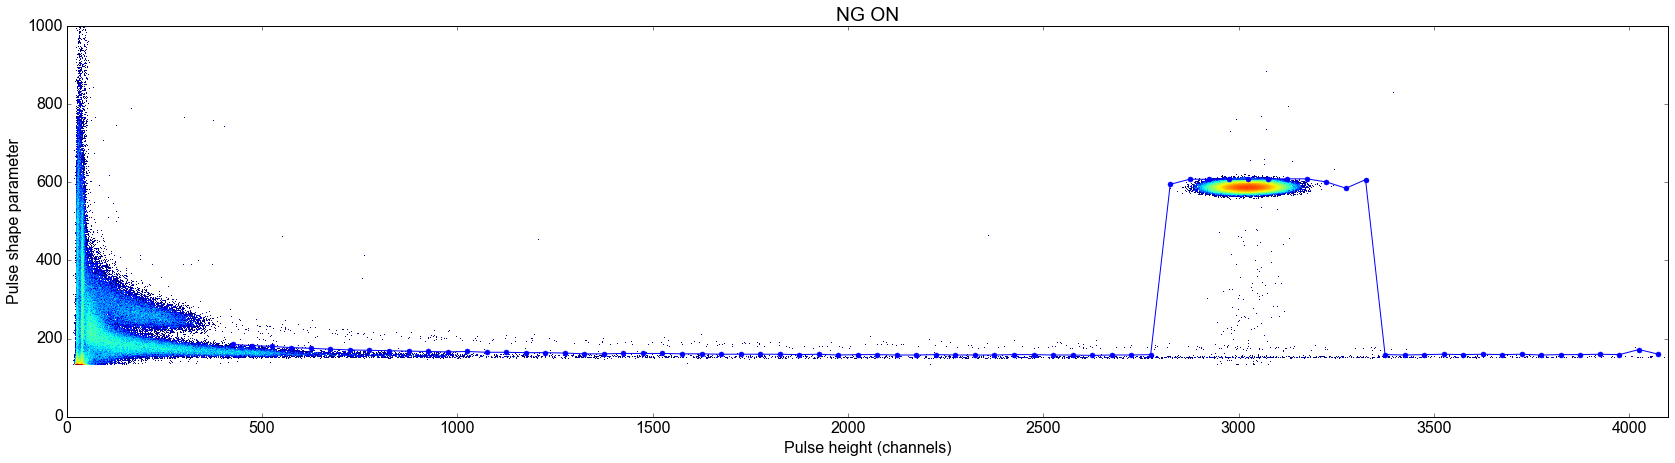

In [54]:
pct = 0.99
cutoffs = []
e_scale_he = []
fg_he = []
bg_he = []

for limit in np.arange(400, 4096, 50):
    dist_bg = np.sum(spec2d_bg[:, limit:limit+50], axis=1)
    current_cutoff = get_percentile_location(dist_bg, pct)
    cutoffs.append(current_cutoff)
    e_scale_he.append(limit+25)
    fg_he.append(np.sum(spec2d[current_cutoff:, limit:limit+50]))
    bg_he.append(np.sum(spec2d_bg[current_cutoff:, limit:limit+50]))
    
# Show the cut
plt.figure(figsize=(30,7))
im = plt.imshow(spec2d, origin='low', interpolation='none', # interpolation='nearest'
                norm=LogNorm())

plt.plot(e_scale_he, cutoffs, marker='.', markersize=10, linestyle='solid')

plt.xlim(0,4100)
plt.ylim(0,1000)
plt.title('NG ON')
plt.xlabel('Pulse height (channels)')
plt.ylabel('Pulse shape parameter')
plt.show()


e_scale_he = poly_1(np.array(e_scale_he), *p_scale_to_e_and)

# Make arrays to enable numpy magic!
# NOTE that these are still NUMBERS and not rate!
fg_he = np.array(fg_he)
bg_he = np.array(bg_he)

# Now calculate Poissonian errors
fg_he_err = 1/(ng_livetimes_0[0] + ng_livetimes_0[1])*np.sqrt(fg_he)
bg_he_err = 1/sum(bg_livetimes_0)*np.sqrt(bg_he)

fg_he = 1/(ng_livetimes_0[0] + ng_livetimes_0[1])*fg_he
bg_he = 1/sum(bg_livetimes_0)*bg_he

fg_he_sub = fg_he - bg_he
fg_he_sub_err = np.sqrt(bg_he_err**2 + fg_he_err**2)



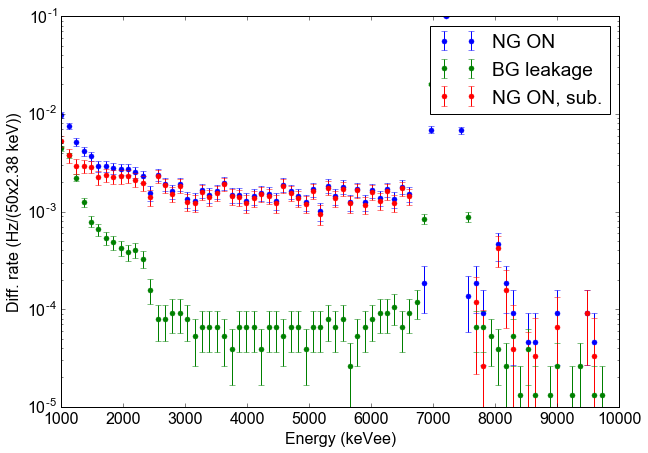

In [55]:
plt.errorbar(e_scale_he,fg_he, fg_he_err, ls='none',marker='.', markersize=10, label='NG ON')
plt.errorbar(e_scale_he,bg_he, bg_he_err, ls='none',marker='.', markersize=10, label='BG leakage')
plt.errorbar(e_scale_he,fg_he_sub, fg_he_sub_err, ls='none',marker='.', markersize=10, label='NG ON, sub.')


plt.ylim(0.00001,0.1)
plt.yscale('log')
plt.xlabel('Energy (keVee)')
plt.ylabel('Diff. rate (Hz/(50x2.38 keV))')
plt.legend()
plt.show()